In [1]:
from deeppavlov.models.bidirectional_lms import elmo_bilm
from deeppavlov.models.tokenizers.lazy_tokenizer import LazyTokenizer
from nltk.tokenize.moses import MosesDetokenizer
import numpy as np
from typing import List
from scipy.stats import kurtosis


import pandas as pd

[nltk_data] Downloading package punkt to /home/sultanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


In [64]:
class ElmoAug:
    
    def __init__(self, model_dir="/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news"):
        self.tokenizer = LazyTokenizer()
        self.elmo_lm   = elmo_bilm.ELMoEmbedder(model_dir=model_dir)
        self.detokenizer = MosesDetokenizer()
        self.tmp_logger = []
        self.logger = []
        self.distributions = []
        self.distributions_num_sent = 0
        
    def _multi_argmax(self, values: np.ndarray, n_instances: int = 1) -> np.ndarray:
        """
        Selects the indices of the n_instances highest values.
        Args:
            values: Contains the values to be selected from.
            n_instances: Specifies how many indices to return.
        Returns:
            Contains the indices of the n_instances largest values.
        """
        assert n_instances <= values.shape[0], 'n_instances must be less or equal than the size of utility'

        max_idx = np.argpartition(-values, n_instances-1, axis=0)[:n_instances]
        return max_idx
    
    def _weighted_sum_distr_by_posistion_in_sent(self, distr):
        weights = (np.arange(len(distr)) + 0.5)/len(distr)
        left = distr[:,0,:]
        right = distr[:,1,:]
        right = right.transpose([1, 0]) * (1-weights)
        right = right.transpose([1, 0])
        left = left.transpose([1, 0]) * weights
        left = left.transpose([1, 0])
        return right + left
    
    def _select_informative_context(self, distr, num_method):
        """
        method 0:
            Kurtosis
        method 1:
            maximum
        method 2:
            minimum along top words
        method 3: random
        """
        left = distr[:, 0, :]
        right = distr[:, 1, :]
        
        if num_method == 0:
            method_func = lambda x: kurtosis(x)
        if num_method == 1:
            method_func = lambda x: np.max(x)
        if num_method == 2:
            method_func = lambda x: np.msort(x)[-5]###5??????
        if num_method == 3:
            return np.array([left[i] if np.random.randint(0, 2) else right[i] for i in range(len(distr))])
            
        
        result_distr = []
        left_func_values = [method_func(l) for l in left]
        right_func_values = [method_func(r) for r in right]
        for i in range(len(left_func_values)):
            if left_func_values[i] > right_func_values[i]:
                result_distr.append(left[i])
            elif left_func_values[i] < right_func_values[i]:
                result_distr.append(right[i])
            else:
                if np.random.randint(0, 2) == 0:
                    result_distr.append(left[i])        
                else:
                    result_distr.append(right[i])
        return np.array(result_distr)


    def _blend_dist(self, batch_distr, num_method):
        """
        blending distr from left and right context
        method 0:
            sum two distr along left right context
        method 1:
            weighted sum by place of word in sentence
        method 2:
            only left context
        method 3:
            only right context
        method 4:
            or left or right context, select basing on 
            method 0:
            method 1:
            method 2:
        method 7:
            random side
        """
        if num_method == 0:
            return [np.sum(distr, axis=1) for distr in batch_distr]
        
        elif num_method == 1:
            return [self._weighted_sum_distr_by_posistion_in_sent(distr) for distr in batch_distr]
        
        elif num_method == 2:
            return [distr[:,0,:] for distr in batch_distr]
        
        elif num_method == 3:
            return [distr[:,1,:] for distr in batch_distr]
        
        elif num_method == 4:
            return [self._select_informative_context(distr, 0) for distr in batch_distr]
        
        elif num_method == 5:
            return [self._select_informative_context(distr, 1) for distr in batch_distr]
        
        elif num_method == 6:
            return [self._select_informative_context(distr, 2) for distr in batch_distr]
        
        elif num_method == 7:
            return [self._select_informative_context(distr, 3) for distr in batch_distr]
    
    def _softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def _sample_distr(self, distr):
        """Sampling from given distribution"""
        threshold = np.random.random_sample()
        i = 0
        while threshold - distr[i] > 0:
            threshold -= distr[i]
            i += 1
        return i
    
    def _sent_aug(self, source_sentence, distr, n_top_words, replace_freq: float=1):
        result = []
        my_true = 0#+
        my_sum = 0#+
        for i, token in enumerate(source_sentence):
            if np.random.rand() < replace_freq:
                words = [self.elmo_lm.get_vocab()[index] for index in self._multi_argmax(distr[i], n_top_words)]    
                p = self._softmax([distr[i, index] for index in self._multi_argmax(distr[i], n_top_words)])
                word = words[self._sample_distr(p)]
                result.append(word)
            else:
                result.append(token)
            if replace_freq == 1:#1
                self.distributions.append({'sent': self.distributions_num_sent, 'source': token,\
                                       'dist': distr[i], 'words': words, 'p': p, 'result': word})#+
        self.tmp_logger.append({'true': my_true, 'sum': my_sum})#+
        self.distributions_num_sent += 1#+
        return result
    
    def _rand_sent_aug(self, source_sentence, distr, n_top_words, replace_freq: float=1):
        result = []
        my_true = 0#+
        my_sum = 0#+
        for i, token in enumerate(source_sentence):
            if np.random.rand() < replace_freq:
                words = [self.elmo_lm.get_vocab()[index] for index in self._multi_argmax(distr[i], n_top_words)]
                #result.append(words[np.random.randint(0, len(words))])
                word = words[np.random.randint(0, len(words))]#1
                result.append(word)#1
                if token in words:#1
                    my_true += 1#1
                    my_sum += 1#1
                else:#1
                    my_sum += 1#1
            else:
                result.append(token)
        self.tmp_logger.append({'true': my_true, 'sum': my_sum})#+
        return result

    
    def _batch_sent(self, batch_sent: List[str], n_top_words: int, replace_freq: float, num_method_blend: int) -> List[str]:
        """
        Replaces some words in the original sentence with words from the language model with frequency p
        Args:
            batch_token: Sentences to be augmented 
            n_top_words: The number of the most likely words from the language model that will be considered as a replacement for the original.
            p: frequency of replacing words
        Returns:
            Contains the augmented sentences
        """
        batch_token    = self.tokenizer(batch_sent)
        batch_distr = self._blend_dist(self.elmo_lm(batch_token), num_method_blend)
        if num_method_blend != 7:
            batch_aug_token = [self._sent_aug(batch_token[i], batch_distr[i], n_top_words, replace_freq) for i in range(len(batch_token))]
        else:
            batch_aug_token = [self._rand_sent_aug(batch_token[i], batch_distr[i], n_top_words, replace_freq) for i in range(len(batch_token))]
        self.logger.append({'method': num_method_blend, **pd.DataFrame(self.tmp_logger).sum().to_dict()})
        self.tmp_logger = []
        return batch_aug_token        
    
    def __call__(self, batch_sent: List[str], n_top_words: int, replace_freq: float, num_method_blend: int):
        batch_aug_token = self._batch_sent(batch_sent, n_top_words, replace_freq, num_method_blend)
        return [self.detokenizer.detokenize(i, return_str=True) for i in batch_aug_token]

In [66]:
el = ElmoAug()

****************************************************************************************************
/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news
USING SKIP CONNECTIONS
INFO:tensorflow:Restoring parameters from /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news/model.ckpt-935588


2018-10-23 14:43:06.523 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news/model.ckpt-935588


In [18]:
test_sentences = \
["Almost half of all iPhone owners have broken their screens, not just once but an average of two times each.",\
   "i really don't understand your point.\xa0 It seems that you are mixing apples and oranges.",\
   "shut the fuck up. you and the rest of your faggot friends should be burned at the stake",\
   "That you are an idiot who understands neither taxation nor women's health.",\
   "What on Earth is that about? Is it what's going to get him fired eventually?",\
   "This is a doctrine of constitutional interpretation that says that a constitution is organic and must be read in a broad and liberal manner so as to adapt it to changing times.",\
   "In the 2000s, music notation typically means the written expression of music notes and rhythms on paper using symbols.",\
   "Most of the mathematical notation in use today was not invented until the 16th century.[52] Before that, mathematics was written out in words, limiting mathematical discovery.",\
   "Physical geography deals with the study of processes and patterns in the natural environment like the atmosphere, hydrosphere, biosphere, and geosphere.",\
   "An autobiography is written by the person himself or herself, sometimes with the assistance of a collaborator or ghostwriter."]

In [67]:
%%time
el(test_sentences, 4, 0.5, 0)

CPU times: user 56min 35s, sys: 5min 58s, total: 1h 2min 33s
Wall time: 1min 13s


['Almost half of all the they have broken their free, but just the, again average for three times. of',
 "i'm do n't see your feelings: </S> seems to you are mixing up with apples of",
 'shut to fuck up for you know the rest of the faggot friends should be aimed at at of',
 "The You are a idiot who understands neither taxation nor women's issues care",
 'What on what is that, the </S> it it is going on get us fired eventually?',
 'There, a interpretation a constitutional rule that has, the constitution is not, should be read in a transparent and liberal way so as not be to to changing times.',
 'In the end, he notation typically was the written expression of music. and rhythms. not using symbols.',
 'Most of The mathematical technology in this today was for up by the 16th,. <S> 52 <S> Before I, we was the out of terms, limiting mathematical discovery of',
 ', geography and with the understanding of the weather patterns in the the environment. the atmosphere, the, biosphere, and the lin

In [20]:
data = pd.DataFrame(el.distributions)
data.head()

,dist,p,result,sent,source,words
0,"[4.544703415376716e-06, 0.00041836030140984803...","[0.1942207680565743, 0.18084508422188575, 0.18...",The,0,Almost,"[The, about, nearly, than, Nearly]"
1,"[9.510239067367365e-07, 1.1179478860867675e-05...","[0.2635735089205691, 0.19883537446139776, 0.18...",half,0,half,"[half, percent, all, quarter, a]"
2,"[2.11810237260579e-06, 8.811316365608945e-05, ...","[0.162286743172068, 0.1639505495459191, 0.3534...",",",0,of,"[Not, ,, of, the, not]"
3,"[1.5429069151196018e-05, 0.06114226613203755, ...","[0.2064417834642294, 0.20431342112482312, 0.20...",those,0,all,"[the, of, all, ,, those]"
4,"[8.047718836223794e-06, 0.00016920152484090067...","[0.2024654182359269, 0.19908834651264432, 0.19...",Americans,0,iPhone,"[business, Americans, iPhone, the, theater]"


In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import logging 
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.WARNING) 

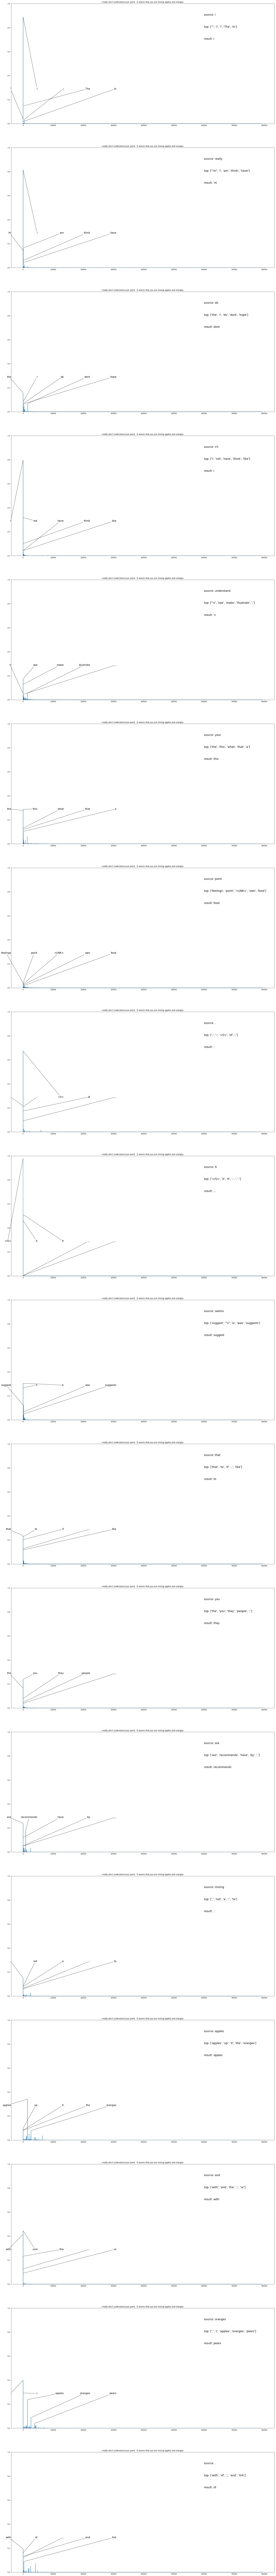

In [75]:
plt.figure(figsize=(30,300))
sent = 1
for num, row in enumerate(data[data['sent']==sent].iterrows()):
    plt.subplot(len(data[data['sent']==sent]), 1, num+1)
    plt.ylim((0,1))
    plt.grid = True
    plt.plot(row[1]['dist'])
    plt.title(test_sentences[row[1]['sent']])
    plt.text(600000, 0.9, f"source: {row[1]['source']}", fontsize='xx-large')
    plt.text(600000, 0.8, f"top: {row[1]['words']}", fontsize='xx-large')
    plt.text(600000, 0.7, f"result: {row[1]['result']}", fontsize='xx-large')
    for num, index in enumerate(el._multi_argmax(row[1]['dist'], 5)):
        plt.annotate(row[1]['words'][num], (index, row[1]['dist'][index]),\
            xytext=(0.1*num, 0.3), textcoords='axes fraction',\
            arrowprops=dict(arrowstyle='-'),\
            fontsize=16,\
            horizontalalignment='right', verticalalignment='top')